## RNN - Google Stock Price

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
stock_data = pd.read_csv('google2014to2019.csv', skiprows=[1])         # download the dataset from google
stock_data.head()

,date,close,volume,open,high,low
0,2019/07/05,1131.59,1264540.0,1117.80,1132.88,1116.140
1,2019/07/03,1121.58,767011.0,1117.41,1126.76,1113.860
2,2019/07/02,1111.25,991755.0,1102.24,1111.77,1098.170
3,2019/07/01,1097.95,1438504.0,1098.00,1107.58,1093.703
4,2019/06/28,1080.91,1693450.0,1076.39,1081.00,1073.370


In [55]:
stock_data['volume'] = stock_data['volume'].astype(np.int64)

In [56]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 6 columns):
date      1259 non-null object
close     1259 non-null float64
volume    1259 non-null int64
open      1259 non-null float64
high      1259 non-null float64
low       1259 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 59.1+ KB


In [57]:
# taking the average of the 'low' and 'high' of the Google stock for the day

import math

stock_data['average'] = (stock_data['high'] + stock_data['low']) / 2
stock_data.head()

,date,close,volume,open,high,low,average
0,2019/07/05,1131.59,1264540,1117.80,1132.88,1116.140,1124.5100
1,2019/07/03,1121.58,767011,1117.41,1126.76,1113.860,1120.3100
2,2019/07/02,1111.25,991755,1102.24,1111.77,1098.170,1104.9700
3,2019/07/01,1097.95,1438504,1098.00,1107.58,1093.703,1100.6415
4,2019/06/28,1080.91,1693450,1076.39,1081.00,1073.370,1077.1850


In [58]:
# Let's take 'average' and 'volume' as our input_data to predict the stock prices.

input_feature = stock_data.iloc[:, [2,6]].values        # 1st we have 'volume' and 2nd 'average'
input_data = input_feature

Text(0, 0.5, 'Volume of Stocks traded')

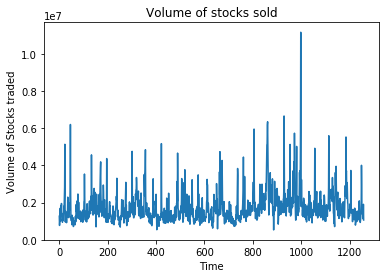

In [61]:
# plot map
plt.plot(input_feature[:,0])               # 'Volume'
plt.title('Volume of stocks sold')
plt.xlabel('Time')
plt.ylabel('Volume of Stocks traded')

Text(0, 0.5, 'Stock Opening Price')

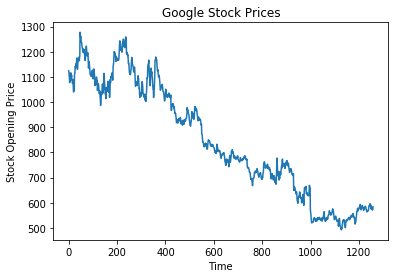

In [62]:
plt.plot(input_feature[:,1])               # 'average'
plt.title('Google Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Opening Price')

In [65]:
# Normalizing the input data using MinMaxScaler so that all the input features are on the scale from 0 to 1

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_feature[:,:])

In [ ]:
-This is a time series problem. If we need to predict the Google stock prices correctly 
then we need to consider the volume as well as the average stock prices from previous days.

-We will be creating the data that will go back to 50 business days in past for the prediction.
-Also, we will take 30 % of the latest data as our test dataset.
-For RNN LSTM to predict the data we need to convert the input data.
-The time series data for today should contain the [Volume of stocks traded, Average stock price] 
for past 50 days and the target variable will be Google’s stock price today and so on.

-As the stock price prediction is based on multiple input features, it is a multivariate regression problem.
-We loop through all the samples and for each day we go back 50 business days in the past 
and add the volume of the stocks traded an average stock price.

In [82]:
lookback = 50

test_size=int(.3 * len(stock_data))    # taking 30 % of the latest data as our test dataset.

X = []
y = []
for i in range(len(stock_data)-lookback-1):
    t=[]                                               # t : timesteps
    for j in range(0, lookback):
        t.append(input_data[[(i+j)], :])
    
    X.append(t)
    y.append(input_data[i + lookback, 1])

In [87]:
# LSTM expects the input data in a specific 3D format of test batch(sample) size, time steps, no. of input features.
# In our case timesteps is 50, number of input features is 2(volume of stocks traded and the average stock price).
# We can transform the input data into LSTM’s expected structure using --> numpy.reshape()

X, y = np.array(X), np.array(y)

X_test = X[: test_size+lookback]

X = X.reshape(X.shape[0], lookback, 2)                 # training         # batch_size, timesteps, input_dim         
X_test = X_test.reshape(X_test.shape[0], lookback, 2)  # testing 

print(X.shape)
print(X_test.shape)

(1208, 50, 2)
(427, 50, 2)


### Our data is now ready and we can build the RNN LSTM model and fit the data.

In [88]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

##### We add 30 RNN cells that will be stacked one after the other in the RNN, implementing an efficient stacked RNN.
##### return_sequences = True , to return the last output in the output sequence.
##### input_shape - will be of the 3D format of test sample size, time steps, no. of input features.

In [89]:
model = Sequential()

model.add(LSTM(units=30, return_sequences=True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))

model.add(Dense(units=1))  

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 30)            3960      
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_9 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [95]:
# Now compile the model and fit

model.compile(optimizer='adam', loss='mean_squared_error')        # metrics=['accuracy']

model.fit(X, y, epochs=20, batch_size=32)        # increase epochs acc.

Epoch 1/20
1208/1208 [==============================] - 16s 13ms/step - loss: 0.0031 - acc: 8.2781e-04
Epoch 2/20
1208/1208 [==============================] - 10s 8ms/step - loss: 0.0014 - acc: 8.2781e-04: 5s - loss: 
Epoch 3/20
1208/1208 [==============================] - 9s 7ms/step - loss: 0.0012 - acc: 8.2781e-04A: 1s - loss: 0.0012 - acc: 9.469
Epoch 4/20
1208/1208 [==============================] - 9s 7ms/step - loss: 0.0012 - acc: 8.2781e-04
Epoch 5/20
1208/1208 [==============================] - 9s 8ms/step - loss: 0.0011 - acc: 8.2781e-04
Epoch 6/20
1208/1208 [==============================] - 9s 8ms/step - loss: 0.0010 - acc: 8.2781e-04
Epoch 7/20
1208/1208 [==============================] - 10s 8ms/step - loss: 0.0011 - acc: 8.2781e-04
Epoch 8/20
1208/1208 [==============================] - 10s 8ms/step - loss: 9.6488e-04 - acc: 8.2781e-046s -
Epoch 9/20
1208/1208 [==============================] - 11s 9ms/step - loss: 0.0010 - acc: 8.2781e-04
Epoch 10/20
1208/1208 [========

In [100]:
# finally predict the stock prices of the test data

predicted_value = model.predict(X_test)

##### We are not doing an inverse scalar function, directly plotting the scaled stock prices and scaled predicted prices.
##### For plotting actual stock prices against the predicted stock prices, we need to start from lookback rows till the size of the test data

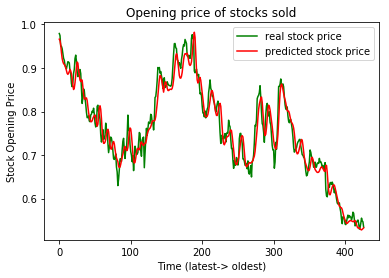

In [104]:
plt.plot(input_data[lookback:test_size + (2*lookback), 1], color='green', label='real stock price') 
plt.plot(predicted_value, color= 'red', label='predicted stock price')

plt.legend()
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()